# EPU - EPIC

EPU(Economic Policy Uncertainty) Index with KDI Economic Policy Information Database

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# for colab
"""!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!cd Mecab-ko-for-Google-Colab
!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh
"""

'!pip install konlpy\n!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git\n!cd Mecab-ko-for-Google-Colab\n!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh\n'

In [3]:
# from konlpy.tag import Mecab
# tagger = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

# Data Load

In [4]:
import os

folder_path = '../data'
all_files = os.listdir(folder_path)

# 2. "epic_metadata_"로 시작하는 파일 필터링
xlsx_files = [f for f in all_files if f.startswith('epic_metadata_') and f.endswith('.xlsx')]

# 3. 각 파일을 읽어서 데이터프레임으로 변환
df_list = []
for file in xlsx_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    df_list.append(df)

# 4. 모든 데이터프레임을 하나로 연결
combined_df = pd.concat(df_list, ignore_index=True)

# 5. 필요 컬럼만 불러오기
df = combined_df.sort_values('발간일').reset_index(drop=True)[['자료명', '발간일','요약']].reset_index(drop=True)

In [5]:
combined_df.head()

,Unnamed: 0,자료명,발간일,발간처,요약
0,104963,금호아시아나그룹 구조조정에 따른 영향 및 대응방안,2009.12.30,금융위원회 기업재무개선지원단,금융위원회에 따르면 2009.12.30일 산업은행과 금호그룹은 주요 계열사별 구조조...
1,104964,2009년 11월중 신설법인 동향,2009.12.31,중소기업청,"중소기업청에 따르면, 11월 신설법인은 4,690개로 전월비로는 3.3%(150개)..."
2,104965,"2010년 녹두, 팥 등 25개 농산물에 대한 특별긴급관세 시행",2009.12.30,기획재정부 세제실 산업관세과,정부는 농산물의 수입증가 또는 수입가격 하락으로 인한 국내산업 피해를 방지하기 위해...
3,104966,"정부, 한국정책금융공사에 산은금융지주사 주식 14.9조원 현물출자 시행",2009.12.31,기획재정부 국고국 출자관리과,기획재정부는 '09.12.30일 한국정책금융공사에 14.9조원 상당의 정부보유 산은...
4,104967,전복 생산자 중심의 자율관리협의체 가동,2010.01.01,농림수산식품부 수산정책실 양식산업과,농식품부는 전복산업의 수급안정과 경쟁력 강화를 위해 금년 1월 1일부터 전복 해상가...


# Keyword

In [6]:
# '요약' 컬럼에 지정된 단어가 포함되어 있는지 확인하는 함수
def contains_keyword(text):
    if isinstance(text, str):  # Check if the entry is a string
        return int(any(keyword in text for keyword in keywords))
    return 0  # If not a string, return 0

In [7]:
data = df.copy()

# keywords = ['불확실성', '불확실', '위기', '위험', '리스크', '불안', '우려', '걱정'] #EPU_KOR_4

keywords = ['불확실성', '불확실'] # EPU_baker

# keywords = ['불확실', '불안']

In [8]:
# 새로운 컬럼 '불확실여부' 생성
data['불확실여부'] = data['요약'].apply(contains_keyword)

# 인덱스 생성

## 날짜 전처리

In [9]:
# 날짜 형식을 datetime 형식으로 변환하는 함수
def convert_to_datetime(date_str):
    # 'yyyy.mm.' 형식인 경우
    if len(date_str) == 8 and date_str[-1] == '.':
        date_str += '01'
    # 'yyyy.mm.dd' 형식이 아니거나, 잘못된 형식인 경우 None 반환
    elif len(date_str) != 10 or not date_str.replace('.', '').isdigit():
        return None
    
    # 유효하지 않은 일자 확인 및 수정
    try:
        date = pd.to_datetime(date_str, format='%Y.%m.%d', errors='raise')
        # 유효하지 않은 월이나 일을 가진 경우 None 반환
        if date.month == 0 or date.day == 0:
            return None
    except ValueError:
        # 잘못된 날짜는 'yyyy.mm.01'로 수정
        date_str = date_str[:8] + '01'
        try:
            date = pd.to_datetime(date_str, format='%Y.%m.%d')
        except ValueError:
            return None
    return date

In [10]:
# '발간일' 컬럼을 datetime 형식으로 변환
data['발간일'] = data['발간일'].apply(convert_to_datetime)

# 필요 날짜만 고르자.
data = data[(data['발간일'] >= '2010-01-01') & (data['발간일'] <= '2024-05-31')]

## EPU Index 생성

In [11]:
def daily_epu(data):
    # 일별로 자료 총 건수와 불확실여부가 1인 자료 건수를 구함
    daily_counts = data.groupby(data['발간일'].dt.date)['불확실여부'].agg(['count', 'sum'])
    daily_counts.columns = ['total_count', 'uncertainty_count']
    
    # 불확실도 계산 (불확실여부가 1인 자료 건수 / 총 자료 건수)
    daily_counts['불확실도'] = daily_counts['uncertainty_count'] / daily_counts['total_count']
    
    # 1) 불확실도를 계산한 데이터프레임을 날짜를 인덱스로 설정
    daily_uncertainty_index = daily_counts['불확실도']
    return daily_uncertainty_index

In [12]:
def monthly_epu(data):
    # 월별로 자료 총 건수와 불확실여부가 1인 자료 건수를 구함
    monthly_counts = data.groupby(data['발간일'].dt.to_period('M'))['불확실여부'].agg(['count', 'sum'])
    monthly_counts.columns = ['total_count', 'uncertainty_count']
    
    # 불확실도 계산 (불확실여부가 1인 자료 건수 / 총 자료 건수)
    monthly_counts['불확실도'] = monthly_counts['uncertainty_count'] / monthly_counts['total_count']
    
    # 1) 불확실도를 계산한 데이터프레임을 월을 인덱스로 설정
    monthly_uncertainty_index = monthly_counts['불확실도']
    return monthly_uncertainty_index
# 2) 불확실건수로
# monthly_uncertainty_index = monthly_counts['uncertainty_count']

In [13]:
daily_uncertainty_index = daily_epu(data)
monthly_uncertainty_index = monthly_epu(data)

# Visualize

In [16]:
import matplotlib
import matplotlib.font_manager as fm

#fm.get_fo
font_location = 'C:/Windows/Fonts/Hancom Gothic Regular.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

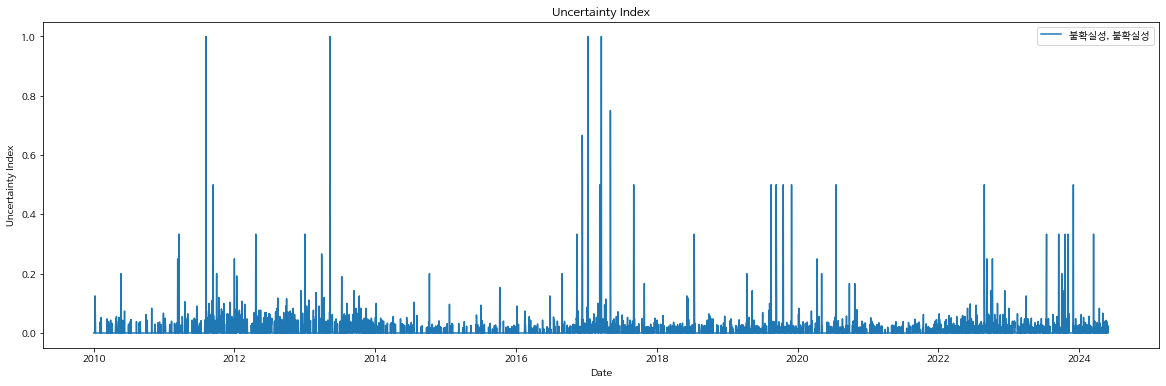

In [37]:
# 선 그래프 그리기
plt.figure(figsize=(20, 6))
daily_uncertainty_index.plot()
plt.title('Uncertainty Index')
plt.xlabel('Date')
plt.ylabel('Uncertainty Index')
plt.legend([w+', '+w for w in keywords])
plt.show()

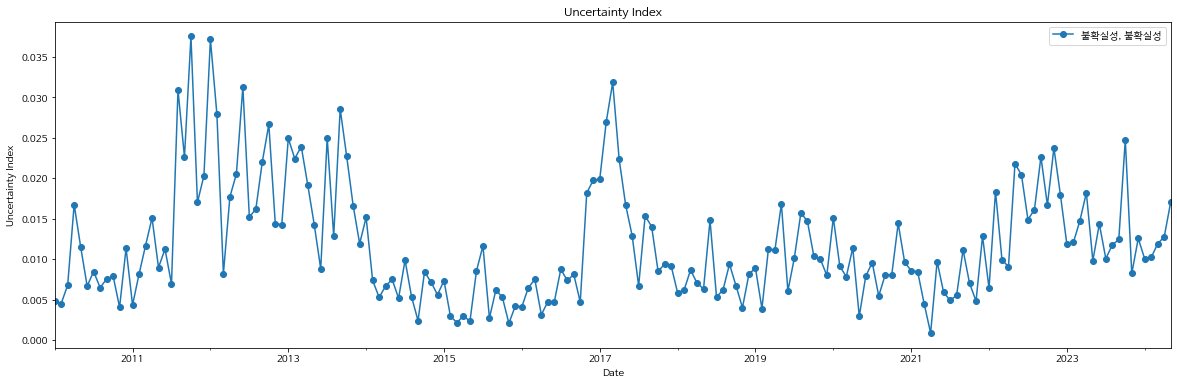

In [38]:
# 선 그래프 그리기
plt.figure(figsize=(20, 6))
monthly_uncertainty_index.plot(marker='o')
plt.title('Uncertainty Index')
plt.xlabel('Date')
plt.ylabel('Uncertainty Index')
plt.legend([w+', '+w for w in keywords])
plt.show()

In [37]:
monthly_uncertainty_index

발간일
2010-01    0.004843
2010-02    0.004515
2010-03    0.006803
2010-04    0.016760
2010-05    0.011538
             ...   
2024-01    0.010020
2024-02    0.010225
2024-03    0.011927
2024-04    0.012766
2024-05    0.017056
Freq: M, Name: 불확실도, Length: 173, dtype: float64